# Dog and Cat Detection

This notebook explores using transfer learning to fine tune a torchvision object detection model to accurately detect cats and dogs in images.

Data obtained from:
https://www.kaggle.com/datasets/andrewmvd/dog-and-cat-detection

https://debuggercafe.com/a-simple-pipeline-to-train-pytorch-faster-rcnn-object-detection-model/

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import PIL
from sklearn.model_selection import train_test_split
import time
import torch
import torchvision
import xml.etree.ElementTree as ET

try:
    from torch_snippets import Report
except:
    !pip install -q torch_snippets
    from torch_snippets import Report

# Connect to GPU is possible.
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device('cpu')

print("Using {}.".format(device))

Using cuda.


# Download Data from Kaggle

https://www.kaggle.com/datasets/andrewmvd/dog-and-cat-detection

In [2]:
if "kaggle.json" not in os.listdir("./"):
    initialize = True
else:
    initialize = False

if initialize == True:
    !pip install -q kaggle
    from google.colab import files
    files.upload()

if initialize == True:
    !mkdir ~/.kaggle

    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    !kaggle datasets download 'andrewmvd/dog-and-cat-detection'
    !unzip -q dog-and-cat-detection.zip

# Prepare Datasets

In [3]:
label_dict = {"dog": 1, "cat" : 2}
reverse_label_dict = {1: "dog", 2: "cat"}

def xml_to_dict(xml_path):
    # Decode the .xml file
    tree = ET.parse(xml_path)
    root = tree.getroot()
    # Return the image size, object label and bounding box 
    # coordinates together with the filename as a dict.
    return {"filename": xml_path,
            "image_width": int(root.find("./size/width").text),
            "image_height": int(root.find("./size/height").text),
            "image_channels": int(root.find("./size/depth").text),
            "label": root.find("./object/name").text,
            "x1": int(root.find("./object/bndbox/xmin").text),
            "y1": int(root.find("./object/bndbox/ymin").text),
            "x2": int(root.find("./object/bndbox/xmax").text),
            "y2": int(root.find("./object/bndbox/ymax").text)}

class CatDogDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms = None):
        self.root = root
        self.transforms = transforms
        self.files = sorted(os.listdir("images"))
        for i in range(len(self.files)):
            self.files[i] = self.files[i].split(".")[0]
            self.label_dict = label_dict
    def __getitem__(self, i):
        # Load image from disc.
        img = PIL.Image.open(os.path.join(self.root, 
              "images/" + self.files[i] + ".png")).convert("RGB")
        # Load annotation file from disc.
        ann = xml_to_dict(os.path.join(self.root, 
              "annotations/" + self.files[i] + ".xml"))
        # The target is given as a dict.
        target = {}
        target["boxes"] = torch.as_tensor([[ann["x1"], 
                                            ann["y1"], 
                                            ann["x2"], 
                                            ann["y2"]]], 
                                   dtype = torch.float32)
        target["labels"]=torch.as_tensor([label_dict[ann["label"]]],
                         dtype = torch.int64)
        target["image_id"] = torch.as_tensor(i)
        # Apply any transforms to the data if required.
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    def __len__(self):
        return len(self.files)

# Helper Functions

https://github.com/pytorch/vision/tree/v0.12.0/references/detection

### transforms.py

In [4]:
import torchvision.transforms.functional as F
import torchvision.transforms.transforms as T
class Compose:
    """
    Composes several torchvision image transforms 
    as a sequence of transformations.
    Inputs
        transforms: list
            List of torchvision image transformations.
    Returns
        image: tensor
        target: dict
    """
    def __init__(self, transforms = []):
        self.transforms = transforms
    # __call__ sequentially performs the image transformations on
    # the input image, and returns the augmented image.
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [5]:
class ToTensor(torch.nn.Module):
    """
    Converts a PIL image into a torch tensor.
    Inputs
        image: PIL Image
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target = None):
        image = F.pil_to_tensor(image)
        image = F.convert_image_dtype(image)
        return image, target
class RandomHorizontalFlip(T.RandomHorizontalFlip):
    """
    Randomly flips an image horizontally.
    Inputs
        image: tensor
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target = None):
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            if target is not None:
                width, _ = F.get_image_size(image)
                target["boxes"][:, [0, 2]] = width - \
                                     target["boxes"][:, [2, 0]]
        return image, target

In [6]:
def get_transform(train):
    """
    Transforms a PIL Image into a torch tensor, and performs
    random horizontal flipping of the image if training a model.
    Inputs
        train: bool
            Flag indicating whether model training will occur.
    Returns
        compose: Compose
            Composition of image transforms.
    """
    transforms = []
    # ToTensor is applied to all images.
    transforms.append(ToTensor())
    # The following transforms are applied only to the train set.
    if train == True:
        transforms.append(RandomHorizontalFlip(0.5))
        # Other transforms can be added here later on.
    return Compose(transforms)

## Prepare Datasets & Dataloaders

In [7]:
# Train dataset. Set train = True for the image transforms.
train_ds = CatDogDataset("./", get_transform(train = True))
# Validation dataset.
val_ds = CatDogDataset("./", get_transform(train = False))
# Test dataset.
test_ds = CatDogDataset("./", get_transform(train = False))
# Randomly choose the train, validation and test samples.
indices = torch.randperm(len(train_ds)).tolist()
# We split the entire data into 80/20 train-test splits. We further
# split the train set into 80/20 train-validation splits. This leads 
# to 64% train, 16% validation and 20% test.
# Train dataset: 64% of the entire data, or 80% of 80%.
train_ds = torch.utils.data.Subset(train_ds,
          indices[:int(len(indices) * 0.64)])
# Validation dataset: 16% of the entire data, or 20% of 80%.
val_ds = torch.utils.data.Subset(val_ds, 
         indices[int(len(indices) * 0.64):int(len(indices) * 0.8)])
# Test dataset: 20% of the entire data.
test_ds = torch.utils.data.Subset(test_ds, 
         indices[int(len(indices) * 0.8):])
def collate_fn(batch):
    return tuple(zip(*batch))
# Create the DataLoaders from the Datasets.
train_dl = torch.utils.data.DataLoader(train_ds, 
                                 batch_size = 4, 
                                 shuffle = True, 
                         collate_fn = collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds, 
                             batch_size = 4, 
                            shuffle = False, 
                     collate_fn = collate_fn)
test_dl = torch.utils.data.DataLoader(test_ds, 
                               batch_size = 4, 
                              shuffle = False, 
                       collate_fn = collate_fn)

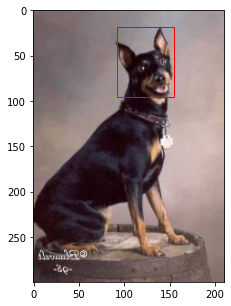

In [8]:
img_index = 3

image, target = train_ds[img_index]
boxes = target["boxes"]

fig, ax = plt.subplots(figsize = [5, 5])
ax.imshow(image.permute(1, 2, 0).numpy())
for i, b in enumerate(boxes):
    rect = patches.Rectangle(b[:2], (b[2] - b[0]), (b[3] - b[1]), 
                             linewidth = 1, edgecolor = "r", facecolor = "none")
    ax.add_patch(rect)
plt.show()

# Build Model

In [9]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_object_detection_model(num_classes = 2, 
                     feature_extraction = True):
    model = fasterrcnn_resnet50_fpn(pretrained = True)
    if feature_extraction == True:
        for p in model.parameters():
            p.requires_grad = False
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats,
                                                    num_classes)
    return model

# Train Model

In [10]:
def unbatch(batch, device):
    """
    Unbatches a batch of data from the Dataloader.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        X: list
            List of images.
        y: list
            List of dictionaries.
    """
    X, y = batch
    X = [x.to(device) for x in X]
    y = [{k: v.to(device) for k, v in t.items()} for t in y]
    return X, y
def train_batch(batch, model, optimizer, device):
    """
    Uses back propagation to train a model.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        optimizer: torch optimizer
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        loss: float
            Sum of the batch losses.
        losses: dict
            Dictionary containing the individual losses.
    """
    model.train()
    X, y = unbatch(batch, device = device)
    optimizer.zero_grad()
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses
@torch.no_grad()
def validate_batch(batch, model, optimizer, device):
    """
    Evaluates a model's loss value using validation data.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        optimizer: torch optimizer
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        loss: float
            Sum of the batch losses.
        losses: dict
            Dictionary containing the individual losses.
    """
    model.train()
    X, y = unbatch(batch, device = device)
    optimizer.zero_grad()
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [11]:
def train_fasterrcnn(model, 
                 optimizer, 
                  n_epochs, 
              train_loader, 
        test_loader = None, 
                log = None, 
               keys = None, 
            device = "cpu"):
    """
    Trains a FasterRCNN model using train and validation 
    Dataloaders.
    Inputs
        model: FasterRCNN
        optimizer: torch optimizer
        n_epochs: int
            Number of epochs to train.
        train_loader: DataLoader
        test_loader: DataLoader
        log: Record
            torch_snippet Record to record training progress.
        keys: list
            List of strs containing the FasterRCNN loss names.
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        log: Record
            torch_snippet Record containing the training records.
    """
    if log is None:
        log = Report(n_epochs)
    if keys is None:
        # FasterRCNN loss names.
        keys = ["loss_classifier", 
                   "loss_box_reg", 
                "loss_objectness", 
               "loss_rpn_box_reg"]
    model.to(device)
    for epoch in range(n_epochs):
        N = len(train_loader)
        for ix, batch in enumerate(train_loader):
            loss, losses = train_batch(batch, model, 
                                  optimizer, device)
            pos = epoch + (ix + 1) / N
            log.record(pos = pos, trn_loss = loss.item(), 
                       end = "\r")
        if test_loader is not None:
            N = len(test_loader)
            for ix, batch in enumerate(test_loader):
                loss, losses = validate_batch(batch, model, 
                                         optimizer, device)
                pos = epoch + (ix + 1) / N
                log.record(pos = pos, val_loss = loss.item(), 
                           end = "\r")
    log.report_avgs(epoch + 1)
    return log

In [12]:
# Create the faster rcnn model with 3 classes - dog, cat and 
# background.
model = get_object_detection_model(num_classes = 3,   
                        feature_extraction = False)
# Use the stochastic gradient descent optimizer.
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.005, 
         momentum = 0.9, weight_decay = 0.0005)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Train the model over 1 epoch.
log = train_fasterrcnn(model = model, 
               optimizer = optimizer, 
                        n_epochs = 1,
             train_loader = train_dl, 
                test_loader = val_dl,
             log = None, keys = None,
                     device = device)

EPOCH: 1.000	trn_loss: 0.124	val_loss: 0.082	(905.78s - 0.00s remaining)


In [14]:
@torch.no_grad()
def predict_batch(batch, model, device):
    """
    Gets the predictions for a batch of data.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        predictions: list
            List of dicts containing the predictions for the 
            bounding boxes, labels and confidence scores.
    """
    model.to(device)
    model.eval()
    X, _ = unbatch(batch, device = device)
    predictions = model(X)
    return [x.cpu() for x in X], predictions
def predict(model, data_loader, device = "cpu"):
    """
    Gets the predictions for a batch of data.
    Inputs
        model: torch model
        data_loader: torch Dataloader
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        predictions: list
            List of dicts containing the predictions for the 
            bounding boxes, labels and confidence scores.
    """
    images = []
    predictions = []
    for i, batch in enumerate(data_loader):
        X, p = predict_batch(batch, model, device)
        images = images + X
        predictions = predictions + p
    
    return images, predictions

In [15]:
def decode_prediction(prediction, 
                      score_threshold = 0.8, 
                      nms_iou_threshold = 0.2):
    """
    Inputs
        prediction: dict
        score_threshold: float
        nms_iou_threshold: float
    Returns
        prediction: tuple
    """
    boxes = prediction["boxes"]
    scores = prediction["scores"]
    labels = prediction["labels"]
    # Remove any low-score predictions.
    if score_threshold is not None:
        want = scores > score_threshold
        boxes = boxes[want]
        scores = scores[want]
        labels = labels[want]
    # Remove any overlapping bounding boxes using NMS.
    if nms_iou_threshold is not None:
        want = torchvision.ops.nms(boxes = boxes, scores = scores, 
                                iou_threshold = nms_iou_threshold)
        boxes = boxes[want]
        scores = scores[want]
        labels = labels[want]
    return (boxes.cpu().numpy(), 
            labels.cpu().numpy(), 
            scores.cpu().numpy())

In [16]:
images, predictions = predict(model, test_dl, device)

In [17]:
#images = []
#targets = []
#for im, tg in test_dl:
#    images = images + [i for i in im]
#    targets = targets + [{k: v for k, v in t.items()} for t in tg]
#print(len(images), len(targets))

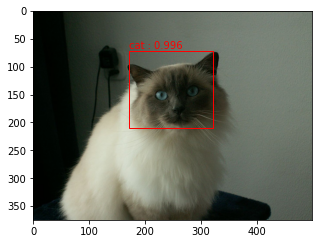

In [18]:
img_index = 200
boxes, labels, scores = decode_prediction(predictions[img_index])
fig, ax = plt.subplots(figsize = [5, 5])
ax.imshow(images[img_index].permute(1, 2, 0).numpy())
for i, b in enumerate(boxes):
    rect = patches.Rectangle(b[:2].astype(int),
                             (b[2] - b[0]).astype(int),
                             (b[3] - b[1]).astype(int),
                             linewidth = 1,
                             edgecolor = "r",
                             facecolor = "none")
    ax.add_patch(rect)
    ax.text(b[0].astype(int),
            b[1].astype(int) - 5,
            "{} : {:.3f}".format(reverse_label_dict[labels[i]],
            scores[i]), color = "r")
plt.show()